# 5.2 Ансамблирование алгоритмов. Случайный лес

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Считаем данные: это характеристики сотрудников некоторой компании. Построим модель, которая предсказывает уход сотрудника.

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/afrozhussain/opendatasets/master/HR-dataset.csv')
print(df.shape)
df.head()

(14999, 11)


,empid,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary
0,1001,0.38,0.53,2,157,3,0,1,0,sales,low
1,1002,0.80,0.86,5,262,6,0,1,0,sales,medium
2,1003,0.11,0.88,7,272,4,0,1,0,sales,medium
3,1004,0.72,0.87,5,223,5,0,1,0,sales,low
4,1005,0.37,0.52,2,159,3,0,1,0,sales,low


In [16]:
target = 'left'
features = df.columns.drop(target)
features = features.drop('empid')  # Удалим идентификатор пользователя как нерепрезентативный признак
print(features)

X, y = df[features].copy(), df[target]

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'dept', 'salary'],
      dtype='object')


In [17]:
salary_ordinals = {'low': 1, 'medium': 2, 'high': 3}

X['dept'] = X['dept'].apply(X['dept'].value_counts().get)
X['salary'] = X['salary'].apply(salary_ordinals.get)

In [18]:
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

В дальнейшем будем оценивать качество модели на кросс-валидации на 5 фолдах при помощи точности (accuracy).

In [19]:
def estimate_accuracy(clf, X, y, cv=5):
    return cross_val_score(clf, X, y, cv=5, scoring='f1').mean()

Посмотрим на то, как работает бэггинг над решающими деревьями.  
__Бэггинг__ (bagging, bootstrap aggregating) $-$ метод построения композиции алгоритмов, в котором каждый алгоритм строится независимо от других на подвыборках обучающей выборки. Итоговый алгоритм принимает решения посредством голосования среди всех алгоритмов (возвращается самый частый ответ).

Посмотрим на точность одного дерева.

In [20]:
tree = DecisionTreeClassifier(max_depth=30)
print("Decision tree:", estimate_accuracy(tree, X, y))

Decision tree: 0.9450045314500757


Проведем бэггинг: для этого достаточно обернуть исходный классификатор в `BaggingClassifier`.

In [9]:
bagging_trees = BaggingClassifier(tree)
print("Decision tree bagging:", estimate_accuracy(bagging_trees, X, y))

Decision tree bagging: 0.9744435917460832


Композиция отдельных деревьев показывает себя лучше чем одно дерево. Структура дерева сильно зависит от обучающей выборки, а значит что, если немного изменить обучающую выборку, то дерево сильно изменится. Бэггинг идеально подходит в этом случае, поскольку композиция алгоритмов при помощи голосования работает наилучшим образом, когда модели различны.

Увеличить различность построенных деревьев можно указав параметры `max_features` и `max_depth`.

In [10]:
random_tree = DecisionTreeClassifier(max_features=int(np.sqrt(len(features))), max_depth=30)
print("Random tree:", estimate_accuracy(random_tree, X, y))

Random tree: 0.9540713833978115


In [11]:
bagging_random_trees = BaggingClassifier(random_tree)
print("Random tree bagging:", estimate_accuracy(bagging_random_trees, X, y))

Random tree bagging: 0.9802463266615942


Именно так внутри и работает так называемый __случайный лес__ (Random Forest): он обучает набор деревьев (параметр `n_esimators`), каждое из которых обучается на подмножестве признаков (Random Subspaces) и на подмножестве объектов (bootstrap). Получается, что случайный лес случаен и по признакам, и по объектам. Ответы каждого дерева аггрегируются при помощи голосования.  
Стандартная эвристика: в задаче классификации брать квадратный корень числа признаков, а в задаче регрессии треть числа признаков.

In [12]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    max_features=int(np.sqrt(len(features))),
    max_depth=30)
print("Random Forest:", estimate_accuracy(random_forest, X, y))

Random Forest: 0.9828361445006276


Еще одно преимущество использования бэггинга для аггрегации моделей: получение оценки работы классификатора без дополнительного проведения кросс-валидации при помощи out-of-bag score.
__Out-of-bag score__ (OOB) $-$ это метод вычисления произвольной оценки качества во время обучения бэггинга. Для этого обученный на подвыборке алгоритм оценивается на тех примерах из всей обучающей выборки, который не попали в подвыборку.  
Для подсчета OOB требуется указать параметр `oob_score = True`. Его имеет смысл указать при достаточном количестве деревьев, иначе выдается ошибка.

In [13]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    max_features=int(np.sqrt(len(features))),
    max_depth=30,
    oob_score=True,
    n_jobs=-1
)
random_forest.fit(X, y)
random_forest.oob_score_.mean()

0.9929995333022201

Метод бэггинга можно применять к произвольным алгоритмам, например к логистической регрессии.

In [13]:
lr = LogisticRegression(solver='saga', max_iter=200)
lr.fit(X, y)
print("LR:", estimate_accuracy(lr, X, y))

LR: 0.4414503588674134


In [14]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=10,
    n_jobs=-1,
    random_state=42
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.43716904240032955


В ее случае он не так сильно повышает качество, поскольку линейные модели не так сильно зависят от состава обучающей выборки.  
Попробуем убрать часть признаков.

In [20]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=10,
    n_jobs=-1,
    max_features=0.5,
    random_state=42
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.2837696640310816


В случае линейной регрессии повышение разнообразности моделей не дает такого прироста как с деревьями, поскольку модели сильно теряют в качестве.

### Сравнение логистической регрессии и случайного леса

In [0]:
def plot_predictions(X, y, clf, proba=False, points_size=7, xlabel='x', ylabel='y'):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_std, y_std = data.std(axis=0)
        x_min, x_max = data[:, 0].min() - x_std / 2, data[:, 0].max() + x_std / 2
        y_min, y_max = data[:, 1].min() - y_std / 2, data[:, 1].max() + y_std / 2
        return np.meshgrid(np.linspace(x_min, x_max, num=200),
                           np.linspace(y_min, y_max, num=200))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.coolwarm, alpha=0.1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.coolwarm, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return clf

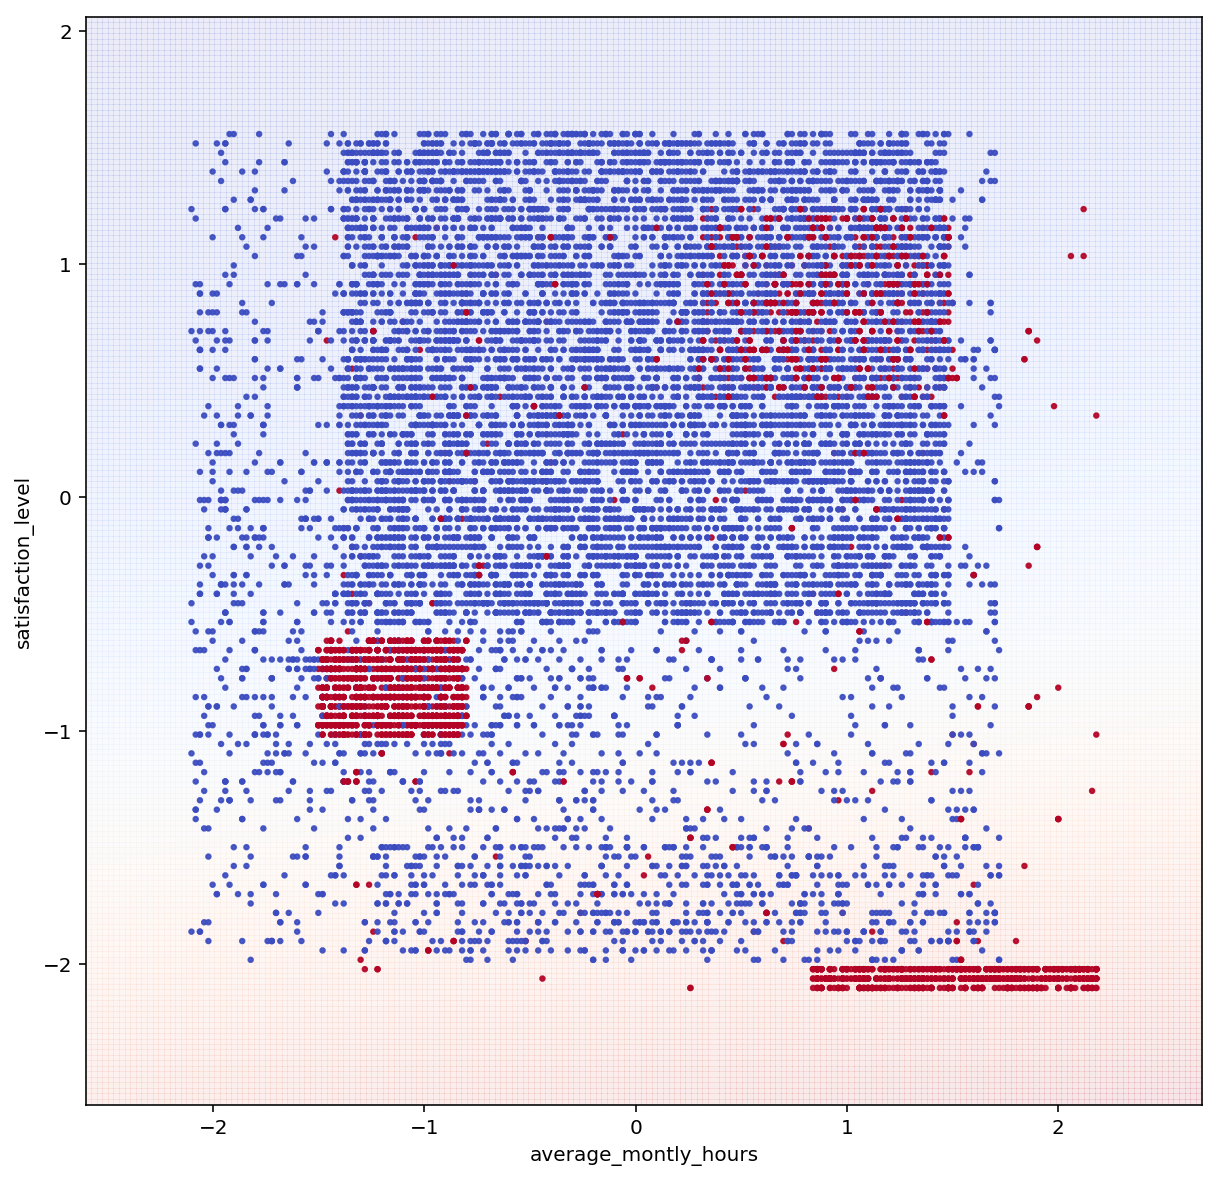

In [17]:
plot_predictions(X[['average_montly_hours', 'satisfaction_level']].values, y,
                 lr,
                 points_size=5,
                 proba=True, xlabel='average_montly_hours', ylabel='satisfaction_level');

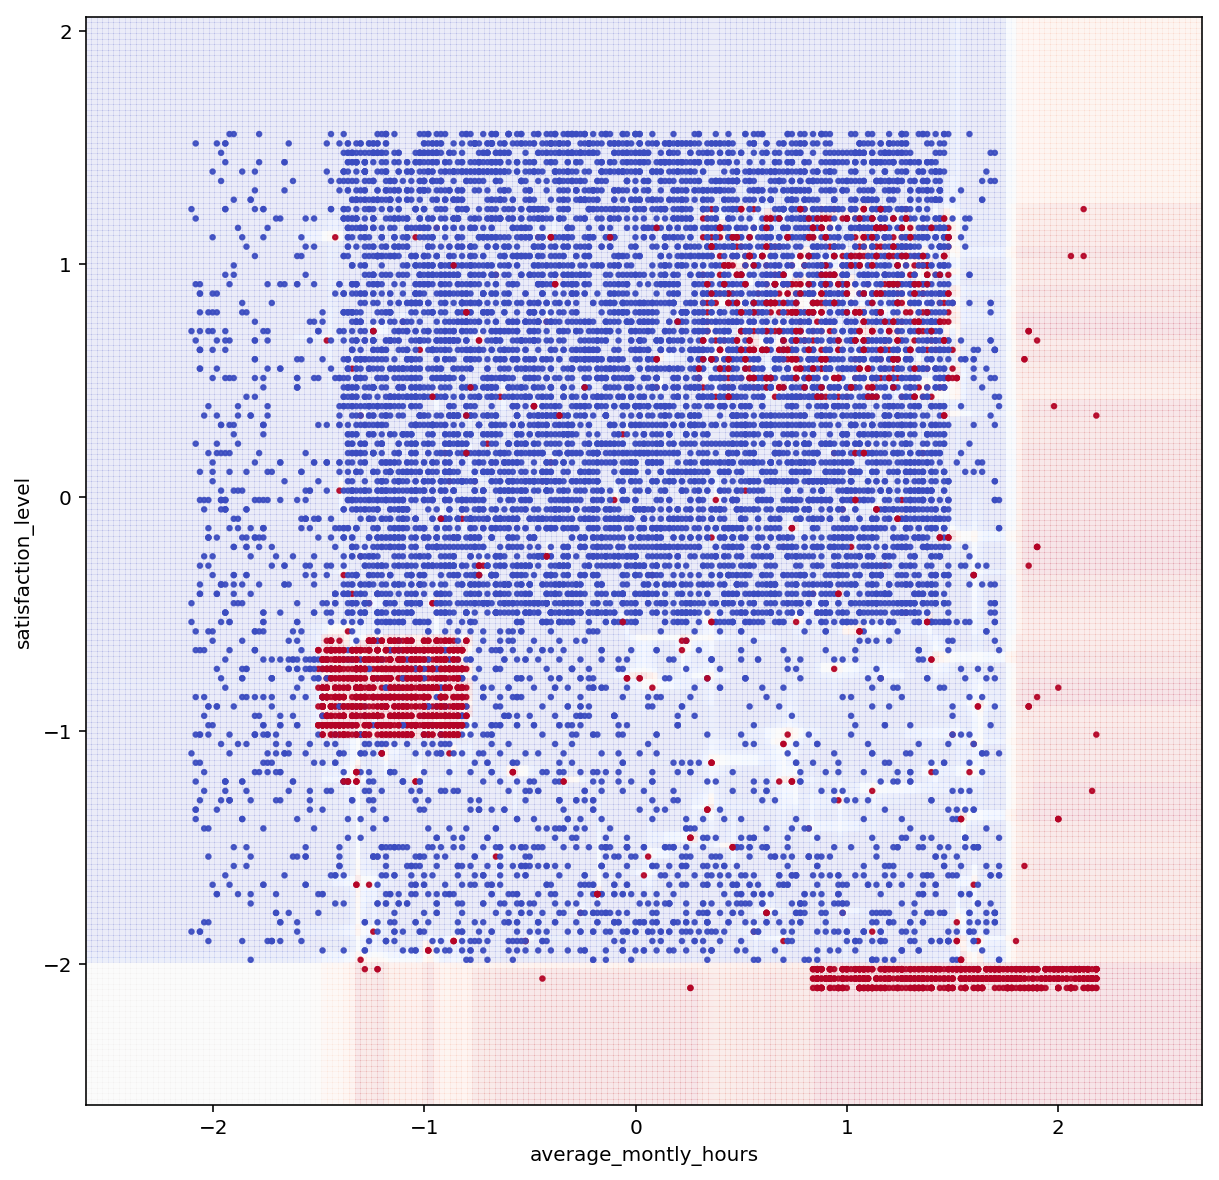

In [18]:
plot_predictions(X[['average_montly_hours', 'satisfaction_level']].values, y,
                 RandomForestClassifier(
                     max_depth=30,
                     n_estimators=100,
                     n_jobs=-1
                 ),
                 points_size=5,
                 proba=True, xlabel='average_montly_hours', ylabel='satisfaction_level');

Дополнительная литература:
* Изменение качества случайного леса в зависимости от числа деревьев: http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html